In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import utils
from utils.train import train_FireEvacuation
from utils.vae import *
import torchvision
from torchvision import datasets, transforms
from utils.utils import *
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Read the data
train_data = np.load('FireEvac_train_set.npy')
test_data = np.load('FireEvac_test_set.npy')
train_data = train_data.astype(np.float32)
test_data = test_data.astype(np.float32)

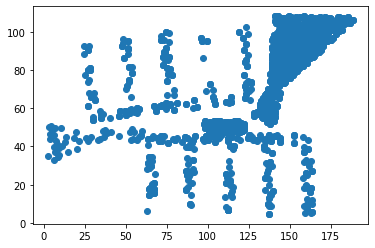

In [5]:
# Plot the training data
plt.scatter(train_data[:,0], train_data[:,1])

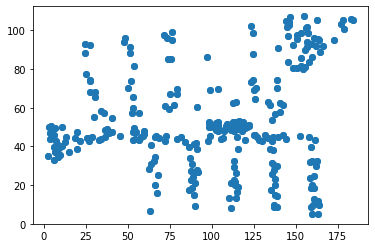

In [6]:
# Plot the Test data
plt.scatter(test_data[:,0], test_data[:,1])

In [27]:
# Would be possible to use softplus but by considering it as logstd we are always positive
obs_dim = 2
latent_dim = 2# Size of the latent variable z
hidden_dim = 256  # Size of the hidden layer in the encoder / decoder

vae = VAE(obs_dim, latent_dim, hidden_dim)

In [28]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=batch_size, shuffle=True
    )
test_loader = torch.utils.data.DataLoader(
        test_data,
        batch_size=600, shuffle=True
    )

In [29]:
# The training depends heavily on the initial conditions, might need to restart it a few times before it finds
# a good initial point for the optimization

train_FireEvacuation(vae, train_loader, test_loader, obs_dim)

Epoch 0
  loss = 42318.300781250
Epoch 1
  loss = 12155.649414062
Epoch 2
  loss = 8303.382812500
Epoch 3
  loss = 5316.411621094
Epoch 4
  loss = 3144.132080078
Epoch 5
  loss = 1946.661010742
Epoch 6
  loss = 1496.659423828
Epoch 7
  loss = 1136.920776367
Epoch 8
  loss = 888.164367676
Epoch 9
  loss = 757.870849609
Epoch 10
  loss = 703.243164062
Epoch 11
  loss = 655.290222168
Epoch 12
  loss = 607.055908203
Epoch 13
  loss = 568.736877441
Epoch 14
  loss = 532.183349609
Epoch 15
  loss = 496.119262695
Epoch 16
  loss = 465.235626221
Epoch 17
  loss = 438.074584961
Epoch 18
  loss = 414.476715088
Epoch 19
  loss = 390.347503662
Epoch 20
  loss = 369.896667480
Epoch 21
  loss = 348.346679688
Epoch 22
  loss = 329.970764160
Epoch 23
  loss = 313.078338623
Epoch 24
  loss = 296.654388428
Epoch 25
  loss = 281.335540771
Epoch 26
  loss = 268.678710938
Epoch 27
  loss = 257.118164062
Epoch 28
  loss = 246.294631958
Epoch 29
  loss = 236.507583618
Epoch 30
  loss = 228.075363159
Epoch 31

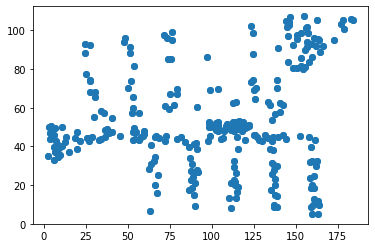

VAE reconstruction:


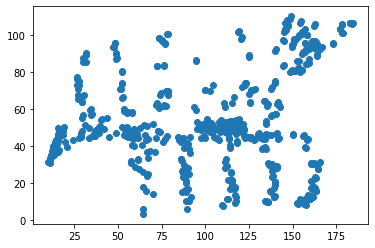

VAE samples:


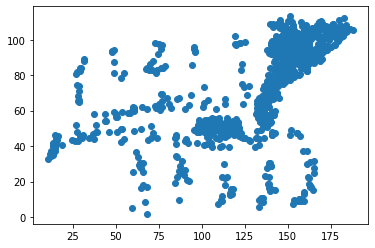

In [34]:
# View original test images
plt.scatter(test_data[:,0], test_data[:,1])
plt.show()
# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
reconstruction = reconstruct_output(test_loader, vae)
plt.scatter(reconstruction[:,0], reconstruction[:,1])
plt.show()
# Sampling
print("VAE samples:")
x = sample(1000, vae)
plt.scatter(x[:,0], x[:,1])
plt.show()

In [394]:
x = sample(100, vae)
# Add generated coordinates to scenario file
for coord in x:
    add_pedestrians(coord)